In [59]:
print("....... chapter 6 yayayaayay")

....... chapter 6 yayayaayay


In [60]:
import urllib.request
import zipfile
import os 
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"

zip_path = "sms_path_collection.zip"
extracted_path = "sms_spam_collection"

data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def downlaod_and_unzip_spam_data(
        url , zip_path , extracted_path , data_file_path):
    
    if data_file_path.exists():
        print(f"{data_file_path} already exists . skipping download and extraction")
        return
    with urllib.request.urlopen(url) as resposne:
        with open(zip_path , 'wb') as out_file:
            out_file.write(resposne.read())
    with zipfile.ZipFile(zip_path ,'r') as zip_ref:
        zip_ref.extractall(extracted_path)
    original_file_path  = Path(extracted_path) / 'SMSSpamCollection'
    os.rename(original_file_path , data_file_path)
    print(f'File downloaded and saved as {data_file_path}')            


In [61]:
downlaod_and_unzip_spam_data(url, 
                             zip_path,
                             extracted_path,
                             data_file_path)

sms_spam_collection/SMSSpamCollection.tsv already exists . skipping download and extraction


In [62]:
import pandas as pd
df = pd.read_csv(
    data_file_path,
    sep='\t',
    header=None,
    names=['Label', 'text']
)
df

,Label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [63]:
print(df['Label'].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


In [64]:
def create_balanced_dataset(df):
    num_spam = df[df['Label'] == "spam"].shape[0]
    ham_subset = df[df["Label"] == 'ham'].sample(
        num_spam , random_state = 123,
    )
    balanced_df = pd.concat([
        ham_subset , df[df['Label']=='spam']
    ])

    return balanced_df

balanced_df = create_balanced_dataset(df)


In [65]:
balanced_df

,Label,text
4307,ham,Awww dat is sweet! We can think of something t...
4138,ham,Just got to &lt;#&gt;
4831,ham,"The word ""Checkmate"" in chess comes from the P..."
4461,ham,This is wishing you a great day. Moji told me ...
5440,ham,Thank you. do you generally date the brothas?
...,...,...
5537,spam,Want explicit SEX in 30 secs? Ring 02073162414...
5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,spam,Had your contract mobile 11 Mnths? Latest Moto...
5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...


In [66]:
balanced_df['Label'].value_counts()

Label
ham     747
spam    747
Name: count, dtype: int64

In [67]:
balanced_df['Label']=balanced_df['Label'].map({'spam':0 , "ham":1})

In [68]:
balanced_df

,Label,text
4307,1,Awww dat is sweet! We can think of something t...
4138,1,Just got to &lt;#&gt;
4831,1,"The word ""Checkmate"" in chess comes from the P..."
4461,1,This is wishing you a great day. Moji told me ...
5440,1,Thank you. do you generally date the brothas?
...,...,...
5537,0,Want explicit SEX in 30 secs? Ring 02073162414...
5540,0,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,0,Had your contract mobile 11 Mnths? Latest Moto...
5566,0,REMINDER FROM O2: To get 2.50 pounds free call...


In [69]:
def random_split(df, train_fac, val_fac):
    df = df.sample(frac = 1,random_state=123).reset_index(drop=True)

    train_end = int(len(df) * train_fac)
    val_end = train_end + int(len(df) * val_fac)


    train_df = df[:train_end]
    validation_df = df[train_end:val_end]
    test_df = df[val_end:]

    return train_df,validation_df,test_df

train_df,val_df,test_df = random_split(balanced_df,0.7,0.1)


In [70]:
train_df.to_csv('train.csv',index=None)
val_df.to_csv('val.csv',index=None)
test_df.to_csv('test.csv',index=None)

In [71]:
import tiktoken
tokenizer = tiktoken.get_encoding('gpt2')
tokenizer.encode("<|endoftext|>",allowed_special={"<|endoftext|>"})

[50256]

In [72]:
import torch 
from torch.utils.data import Dataset
import pandas as pd  # Added missing import

class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        super().__init__()
        self.data = pd.read_csv(csv_file)

        self.encoded_texts = [tokenizer.encode(text) for text in self.data['text']]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
        
        # Apply truncation first
        self.encoded_texts = [
            encoded_text[:self.max_length] for encoded_text in self.encoded_texts
        ]    

        # Apply padding
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]    

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        ) 

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length


In [73]:
train_dataset = SpamDataset(
    csv_file='train.csv',
    tokenizer=tokenizer,
    max_length=None
)

In [74]:
print(train_dataset.max_length)

120


In [75]:
val_dataset = SpamDataset(
    csv_file='val.csv',
    tokenizer=tokenizer,
    max_length=train_dataset.max_length
)
test_dataset = SpamDataset(
    csv_file='test.csv',
    tokenizer=tokenizer,
    max_length=train_dataset.max_length
)

In [76]:
padded_train_dataset = SpamDataset(
    csv_file='train.csv',
    tokenizer=tokenizer,
    max_length=1024
)
padded_val_dataset = SpamDataset(
    csv_file='val.csv',
    tokenizer=tokenizer,
    max_length=train_dataset.max_length
)
padded_test_dataset = SpamDataset(
    csv_file='test.csv',
    tokenizer=tokenizer,
    max_length=train_dataset.max_length
)

In [77]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8
torch.manual_seed(123)

train_dataloader = DataLoader(
    num_workers = 0,
    batch_size = batch_size,
    shuffle = True,
    dataset=train_dataset,
    drop_last = True
)

val_dataloader = DataLoader(
    num_workers = 0,
    batch_size = batch_size,
    shuffle = True,
    dataset=val_dataset,
    drop_last = True
)

test_dataloader = DataLoader(
    num_workers = 0,
    batch_size = batch_size,
    shuffle = True,
    dataset=test_dataset,
    drop_last = True
)

In [78]:
for input_batch , target_batch in train_dataloader:
    pass

print("Input batch size:",input_batch.shape)
print("target batch size:",target_batch.shape)

Input batch size: torch.Size([8, 120])
target batch size: torch.Size([8])


In [79]:
print("training set length:",len(train_dataloader))
print("val set length:",len(val_dataloader))
print("test set length:",len(test_dataloader))

training set length: 130
val set length: 18
test set length: 37


In [22]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size":50257,
    "context_length":1024,
    "drop_rate":0.0,
    "bias_":True
}


model_configs = {
    "gpt2-small (124M)":{"emb_dim":768,"n_layers":12,"n_heads":12},
    "gpt2-medium (355M)":{"emb_dim":1024,"n_layers":24,"n_heads":16},
    "gpt2-large (774M)":{"emb_dim":1280,"n_layers":36,"n_heads":20},
    "gpt2-xl (1558M)":{"emb_dim":1600,"n_layers":48,"n_heads":25}

}

BASE_CONFIG.update(
    model_configs[CHOOSE_MODEL]
)

In [23]:
BASE_CONFIG

{'vocab_size': 50257,
 'context_length': 1024,
 'drop_rate': 0.0,
 'bias_': True,
 'emb_dim': 768,
 'n_layers': 12,
 'n_heads': 12}

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import tiktoken

class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.token_embedding = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.positional_embedding = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        self.drop_emnd = nn.Dropout(cfg['drop_rate'])
        self.transformer_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg['n_layers'])]
        )
        self.final_norm = DummyLayerNorm(cfg['emb_dim'])
        self.out_head = nn.Linear(cfg['emb_dim'], cfg['vocab_size'], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.token_embedding(in_idx)
        pos_embeds = self.positional_embedding(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emnd(x)
        x = self.transformer_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()

    def forward(self, x):
        return x

class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()

    def forward(self, x):
        return x

class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

class Gelu(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))))

class FFN(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            Gelu(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"])
        )

    def forward(self, x):
        return self.layers(x)

class EXResidualConnections(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[i], layer_sizes[i + 1]), Gelu())
            for i in range(len(layer_sizes) - 1)
        ])

    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x)
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x).view(b, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)
        queries = self.W_query(x).view(b, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)
        values = self.W_value(x).view(b, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)
        attn_scores = queries @ keys.transpose(-2, -1)
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        attn_weights = torch.softmax(attn_scores / keys.shape[-1] ** 0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)
        context_vec = attn_weights @ values
        context_vec = context_vec.transpose(1, 2).contiguous().view(b, num_tokens, self.d_out)
        return self.out_proj(context_vec)

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.attention = MultiHeadAttention(
            d_in=cfg['emb_dim'], d_out=cfg['emb_dim'],
            context_length=cfg['context_length'], num_heads=cfg['n_heads'],
            dropout=cfg['drop_rate'], qkv_bias=cfg['bias_']
        )
        self.ff = FFN(cfg)
        self.norm1 = LayerNorm(cfg['emb_dim'])
        self.norm2 = LayerNorm(cfg['emb_dim'])
        self.dropout = nn.Dropout(cfg['drop_rate'])

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.attention(x)
        x = self.dropout(x)
        x = x + shortcut
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.dropout(x)
        return x + shortcut

class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        self.drop_emb = nn.Dropout(cfg['drop_rate'])
        self.trf_blocks = nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg['n_layers'])])
        self.final_norm = LayerNorm(cfg['emb_dim'])
        self.out_head = nn.Linear(cfg['emb_dim'], cfg['vocab_size'], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        token_embds = self.tok_emb(in_idx)
        pos_emb = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = token_embds + pos_emb
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        return self.out_head(x)


In [13]:
from gpt_download import download_and_load_gpt2



model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
model_size=model_size, models_dir="gpt2"
)
model = GPTModel(BASE_CONFIG)

load_weights_into_gpt(model,params)
model.eval()

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FFN(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): Gelu()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768

In [18]:
from chap4 import generate_text_simple
from chap5 import token_ids_to_text,text_to_token_ids
import tiktoken 
tokenizer = tiktoken.get_encoding('gpt2')

text_1 = "Gods plan"
generated_text_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1,tokenizer=tokenizer),
    max_new_tokens = 15,
    context_size = BASE_CONFIG['context_length']
    
)

In [19]:
token_ids_to_text(generated_text_ids,tokenizer)

'Gods plan to use the new technology to help them fight off the threat of the undead'

In [22]:
text2 = (
    "Is the folllowing text spam or not Answer with yes or No:"
    "'Mam you are selected for a lotter click this link to receive 10000 dollars'"
)

token_ids =  generate_text_simple(
    model=model,
    idx=text_to_token_ids(text2,tokenizer=tokenizer),
    max_new_tokens = 15,
    context_size = BASE_CONFIG['context_length']
    )

In [25]:
token_ids_to_text(token_ids,tokenizer=tokenizer)

"Is the folllowing text spam or not Answer with yes or No:'Mam you are selected for a lotter click this link to receive 10000 dollars'\n\nThe spam is not spamming you, it is spamming you"

In [26]:
model

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FFN(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): Gelu()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768

In [27]:
for params in model.parameters():
    params.requires_grad=False

In [29]:
import torch
torch.manual_seed(123)
num_classes=2
model.out_head = torch.nn.Linear(
    in_features=BASE_CONFIG['emb_dim'],
    out_features=num_classes
)

In [30]:
model

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FFN(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): Gelu()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768

In [34]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad=True

for param in model.final_norm.parameters():
    param.requires_grad = True


In [39]:
inputs = tokenizer.encode("DO u have time")
inputs=torch.tensor(inputs).unsqueeze(0)
print("Inputs:",inputs)
print("input dim:",inputs.shape)

Inputs: tensor([[18227,   334,   423,   640]])
input dim: torch.Size([1, 4])


In [42]:
with torch.no_grad():
    outputs=model(inputs)
print("Outputs:",outputs)    
print("Outputs shape:",outputs.shape)  

Outputs: tensor([[[-1.6555,  1.0098],
         [-4.2037,  3.9974],
         [-2.6591,  5.6201],
         [-3.8923,  4.5017]]])
Outputs shape: torch.Size([1, 4, 2])


In [46]:
torch.argmax(outputs[:,-1,:])

tensor(1)

In [47]:
outputs[:,-1,:]

tensor([[-3.8923,  4.5017]])

In [51]:
probas=torch.softmax(outputs[:,-1,:],dim=-1)
label=torch.argmax(probas)
print("class label:",label.item())


class label: 1


In [52]:

label=torch.argmax(outputs[:,-1,:])
print("class label:",label.item())

class label: 1


In [54]:
def calc_accuracy(data_loader,model,device,num_batches=None):
    model.eval()
    correct_predictions,num_examples=0,0

    if num_batches is None:
        num_batches=len(data_loader)
    else:
        num_batches = min(num_batches,len(data_loader))
    for i,(input_batch,target_batch) in enumerate(data_loader):
        if i<num_batches:
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:,-1,:]
            predicted_labels = torch.argmax(logits,
                                            dim=-1) 
            num_examples+=predicted_labels.shape[0]
            correct_predictions +=(
                (predicted_labels == target_batch).sum().item()
            )     
        else:
            break
    return correct_predictions/num_examples          
            


In [86]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

torch.manual_seed(123)
train_accuracy = calc_accuracy(
    train_dataloader , model=model, device=device,num_batches=10
)

val_accuracy = calc_accuracy(
    val_dataloader , model=model, device=device,num_batches=10
)

test_accuracy = calc_accuracy(
    test_dataloader,model=model, device=device,num_batches=10
)

In [87]:
print("train accuracy in percentage:",train_accuracy*100)
print("val-accuracy in percentage:",val_accuracy*100)
print("test-accuracy in percentage:",test_accuracy*100)

train accuracy in percentage: 53.75
val-accuracy in percentage: 46.25
test-accuracy in percentage: 50.0


In [102]:
def calc_loss_batch(input_batch,target_batch,model,device):
    input_batch = input_batch.to(device)
    target_batch=target_batch.to(device)
    logits = model(input_batch)[:,-1,:]
    loss = torch.nn.functional.cross_entropy(logits,target_batch)
    return loss


In [119]:
def calc_loss(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else: #1
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(
            input_batch, target_batch, model, device
            )
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [120]:
with torch.no_grad():
    print("[DEBUG] Calculating training loss...")
    train_loss = calc_loss(train_dataloader, model=model, device=device, num_batches=5)

    print("[DEBUG] Calculating validation loss...")
    val_loss = calc_loss(val_dataloader, model=model, device=device, num_batches=5)

    print("[DEBUG] Calculating test loss...")
    test_loss = calc_loss(test_dataloader, model=model, device=device, num_batches=5)


[DEBUG] Calculating training loss...
[DEBUG] Calculating validation loss...
[DEBUG] Calculating test loss...


In [121]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss(
            train_loader, model, device, num_batches=eval_iter
            )
        val_loss = calc_loss(
            val_loader, model, device, num_batches=eval_iter
            )
    model.train()
    return train_loss, val_loss





def train_classifier_simple(
        model, train_loader, val_loader, optimizer, device,
        num_epochs, eval_freq, eval_iter
):
    train_losses, val_losses, train_accs, val_accs = [], [], [], [] 
    examples_seen, global_step = 0, -1
    
    for epoch in range(num_epochs):  # 2
        model.train()  # 3
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()  # 4
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            loss.backward()  # 5
            optimizer.step()  # 6
            examples_seen += input_batch.shape[0]  # 7
            global_step += 1  # 1

            # 8
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, "
                      f"Val loss {val_loss:.3f}"
                      )

            # 9
            train_accuracy = calc_accuracy(
                train_loader, model, device, num_batches=eval_iter
            )
            val_accuracy = calc_accuracy(
                val_loader, model, device, num_batches=eval_iter
            )

            print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
            print(f"Validation accuracy: {val_accuracy*100:.2f}%")

            train_accs.append(train_accuracy)
            val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen


In [123]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(),
                              lr=5e-5,
                              weight_decay=0.1)
num_epochs = 2

train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model=model,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=50,
    eval_iter=5
)
end_time = time.time()

Ep 1 (Step 000000): Train loss 0.135, Val loss 0.005
Training accuracy: 100.00% | Validation accuracy: 100.00%
Training accuracy: 100.00% | Validation accuracy: 97.50%
Training accuracy: 95.00% | Validation accuracy: 100.00%
Training accuracy: 97.50% | Validation accuracy: 97.50%
Training accuracy: 100.00% | Validation accuracy: 100.00%
Training accuracy: 100.00% | Validation accuracy: 97.50%
Training accuracy: 97.50% | Validation accuracy: 100.00%
Training accuracy: 100.00% | Validation accuracy: 97.50%
Training accuracy: 97.50% | Validation accuracy: 100.00%
Training accuracy: 97.50% | Validation accuracy: 97.50%
Training accuracy: 95.00% | Validation accuracy: 100.00%
Training accuracy: 100.00% | Validation accuracy: 100.00%
Training accuracy: 97.50% | Validation accuracy: 100.00%
Training accuracy: 95.00% | Validation accuracy: 95.00%
Training accuracy: 97.50% | Validation accuracy: 100.00%
Training accuracy: 97.50% | Validation accuracy: 97.50%
Training accuracy: 97.50% | Validati

In [124]:
execution_time = (end_time - start_time)/60

In [125]:
print(f"Training completed in {execution_time:.2f} minutes")

Training completed in 32.97 minutes


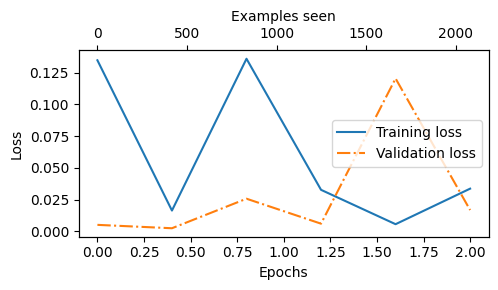

In [137]:
import matplotlib.pyplot as plt
def plot_values(
    epochs_seen, examples_seen, train_values, val_values,
    label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))
#1
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(
    epochs_seen, val_values, linestyle="-.",
    label=f"Validation {label}"
)
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()
#2
    ax2 = ax1.twiny()
    ax2.plot(examples_seen, train_values, alpha=0) #3
    ax2.set_xlabel("Examples seen")
    fig.tight_layout() #4
    plt.savefig(f"{label}-plot.pdf")
    plt.show()
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

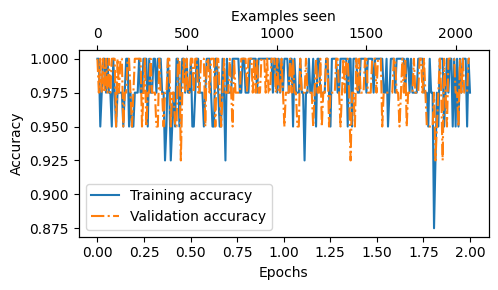

In [138]:
epochs_tensor = torch.linspace(
    0, num_epochs, len(train_accs)
)
examples_seen_tensor = torch.linspace(
    0, examples_seen, len(train_accs)
)

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label='accuracy')

2

In [141]:
train_accuracy = calc_accuracy(train_dataloader, model, device)
val_accuracy = calc_accuracy(val_dataloader, model, device)
test_accuracy = calc_accuracy(test_dataloader, model, device)
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 98.65%
Validation accuracy: 97.92%
Test accuracy: 95.95%


In [147]:
def classify_review(
    text, model, tokenizer, device, max_length=None,
    pad_token_id=50256):
    model.eval()
    input_ids = tokenizer.encode(text) #1
    supported_context_length = model.pos_emb.weight.shape[1]
    input_ids = input_ids[:min( #2
    max_length, supported_context_length
        )]
    input_ids += [pad_token_id] * (max_length - len(input_ids)) 
    input_tensor = torch.tensor(
    input_ids, device=device
    ).unsqueeze(0) #4
    with torch.no_grad(): #5
        logits = model(input_tensor)[:, -1, :] #6
        predicted_label = torch.argmax(logits, dim=-1).item()
    return "spam" if predicted_label == 0 else "not spam" 

In [148]:
text_1 = (
"You are a winner you have been specially"
" selected to receive $1000 cash or a $2000 award."
)
print(classify_review(
text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

spam


In [149]:
text_2 = (
"respected sir I am bhavya goyal for google deepmind we have selected u for interveiw please attach your cv"
)
print(classify_review(
text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam


In [151]:
torch.save(model.state_dict(), "review_classifier.pth")